<a href="https://colab.research.google.com/github/soniaeya/Multilingual_Classifier/blob/main/COMP6781_Final_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Preprocessing & Data Analysis 👩🏻‍💻

We will start here with the data preprocessing of both the datasets.

We will here remove symbols, special characters, emojiis, duplicates and put all the words to lowercase.

Knowing that one of our datasets is using data from social media posts, we are aware that some of the instances in the data might contain abbreviation, for this project we will be leaving the in the datasets.

We will also be removing some 'useless' data such as columns such as likecount.


In [1]:
!pip install -U datasets transformers pyarrow pandas
!pip install -U "pyarrow<18.0.0" "datasets" "pandas"

  Using cached pyarrow-17.0.0-cp312-cp312-manylinux_2_28_x86_64.whl.metadata (3.3 kB)
INFO: pip is looking at multiple versions of datasets to determine which version is compatible with other requirements. This could take a while.
  Using cached datasets-4.4.1-py3-none-any.whl.metadata (19 kB)
  Using cached datasets-4.4.0-py3-none-any.whl.metadata (19 kB)
  Using cached datasets-4.3.0-py3-none-any.whl.metadata (18 kB)
  Using cached datasets-4.2.0-py3-none-any.whl.metadata (18 kB)
INFO: pip is still looking at multiple versions of datasets to determine which version is compatible with other requirements. This could take a while.
  Using cached datasets-4.1.1-py3-none-any.whl.metadata (18 kB)
  Using cached datasets-4.1.0-py3-none-any.whl.metadata (18 kB)
INFO: This is taking longer than usual. You might need to provide the dependency resolver with stricter constraints to reduce runtime. See https://pip.pypa.io/warnings/backtracking for guidance. If you want to abort this run, press Ct

In [2]:
# Install dependencies as needed:
# pip install kagglehub[pandas-datasets]
import kagglehub
from kagglehub import KaggleDatasetAdapter

# Set the path to the file you'd like to load
file_path = "News _dataset/Fake.csv"

# Load the latest version
fake_df = kagglehub.load_dataset(
  KaggleDatasetAdapter.PANDAS,
  "emineyetm/fake-news-detection-datasets",
  file_path,
  # Provide any additional arguments like
  # sql_query or pandas_kwargs. See the
  # documenation for more information:
  # https://github.com/Kaggle/kagglehub/blob/main/README.md#kaggledatasetadapterpandas
)


/tmp/ipython-input-3202423662.py:10: DeprecationWarning: Use dataset_load() instead of load_dataset(). load_dataset() will be removed in a future version.
  fake_df = kagglehub.load_dataset(


Using Colab cache for faster access to the 'fake-news-detection-datasets' dataset.


In [3]:
# Install dependencies as needed:
# pip install kagglehub[pandas-datasets]
import kagglehub
from kagglehub import KaggleDatasetAdapter

# Set the path to the file you'd like to load
file_path = "News _dataset/True.csv"

# Load the latest version
true_df = kagglehub.load_dataset(
  KaggleDatasetAdapter.PANDAS,
  "emineyetm/fake-news-detection-datasets",
  file_path,
  # Provide any additional arguments like
  # sql_query or pandas_kwargs. See the
  # documenation for more information:
  # https://github.com/Kaggle/kagglehub/blob/main/README.md#kaggledatasetadapterpandas
)


/tmp/ipython-input-3023788996.py:10: DeprecationWarning: Use dataset_load() instead of load_dataset(). load_dataset() will be removed in a future version.
  true_df = kagglehub.load_dataset(


Using Colab cache for faster access to the 'fake-news-detection-datasets' dataset.


In [17]:
import pandas as pd
from sklearn.model_selection import train_test_split
from datasets import Dataset, DatasetDict

# Ensure label columns are added if not already present from previous execution
if 'label' not in fake_df.columns:
    fake_df['label'] = 0
if 'label' not in true_df.columns:
    true_df['label'] = 1

# Prepare kaggle_df if not already done
if 'kaggle_df' not in locals():
    f_df = fake_df[['text', 'label']]
    t_df = true_df[['text', 'label']]
    kaggle_df = pd.concat([f_df, t_df], ignore_index=True)
    kaggle_df = kaggle_df.rename(columns={'text': 'claim'})

# Split 1: 70% train, 30% temp
train_df, temp_df = train_test_split(kaggle_df, test_size=0.3, random_state=42, stratify=kaggle_df['label'])

# Split 2: 1/3 validation, 2/3 test from temp_df (10% val, 20% test of total)
val_df, test_df = train_test_split(temp_df, test_size=2/3, random_state=42, stratify=temp_df['label'])

# Convert pandas DataFrames to Hugging Face Dataset objects
train_dataset = Dataset.from_pandas(train_df)
val_dataset = Dataset.from_pandas(val_df)
test_dataset = Dataset.from_pandas(test_df)

# Create a DatasetDict
eng_dataset = DatasetDict({
    'train': train_dataset,
    'validation': val_dataset,
    'test': test_dataset
})


Loading the datasets.... 🔌

In [18]:
from datasets import load_dataset

deFakts = load_dataset("ComplexDataLab/Misinfo_Datasets", "defakts")
faviq = eng_dataset



In [19]:


print("\n=== DeFAKTS features ===")
print(deFakts["train"].features)
print("Columns:", deFakts["train"].column_names)


=== DeFAKTS features ===
{'claim': Value('string'), 'veracity': Value('string'), 'dataset': Value('string'), 'label': Value('string'), 'question': Value('string'), 'answer': Value('string'), 'positive_evidence_text': Value('string'), 'positive_evidence_title': Value('string'), 'negative_evidence_text': Value('string'), 'negative_evidence_title': Value('string'), 'split': Value('string'), 'source': Value('string'), 'source_url': Value('string'), 'article_content': Value('string'), 'article_headline': Value('string'), 'author': Value('string'), 'initial_claim': Value('string'), 'fact1': Value('string'), 'fact2': Value('string'), 'fact3': Value('string'), 'fact4': Value('string'), 'num_hops': Value('string'), 'date': Value('string'), 'similarity': Value('string'), 'like_count': Value('string'), 'retweet_count': Value('string'), 'tweet_text': Value('string'), 'tweet_label': Value('string'), 'evidence_1': Value('string'), 'link_evidence_1': Value('string'), 'source_evidence_1': Value('stri

## 🏷️ Here we are building the label maps and the schema of the data sets!

In this part, we are making sure that both datasets have the same schema of data for consistency, i.e. `{'label':0 or 1,
'text': 'claim'}`

We will also check whether both data set are balanced.

*NOTE: The following operation are **only applied to the train split** of the datasets!!*

In [29]:
from datasets import ClassLabel

# %%%%%%%%%%%%%%%%%% FAVIQ 2023 %%%%%%%%%%%%%%%%%%%%%%




faviq_model = faviq.remove_columns(['__index_level_0__'])


# %%%%%%%%%%%%%%%%%% DEFAKTS %%%%%%%%%%%%%%%%%%%%%%

txt_column_deFakts = "claim"
label_column_deFakts = "label"
label_map_deFakts = {"false": 0, "true": 1}


# keeping the rows where the labels are either true or false
valid_labels_deFakts = {"true", "false"}

deFakts_binary = deFakts.filter(lambda example: example[label_column_deFakts] in valid_labels_deFakts)


print("Label values after filtering:", set(deFakts_binary["train"][label_column_deFakts]))

def standardize_deFakts(example):
    return {
        "text": example[txt_column_deFakts],
        "label": label_map_deFakts[example[label_column_deFakts]],
    }

deFakts_model = deFakts_binary.map(
    standardize_deFakts,
    remove_columns=deFakts_binary["train"].column_names
)






Label values after filtering: {'true', 'false'}


Map:   0%|          | 0/13932 [00:00<?, ? examples/s]

Map:   0%|          | 0/4090 [00:00<?, ? examples/s]

Map:   0%|          | 0/1986 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['label', 'text'],
        num_rows: 13932
    })
    test: Dataset({
        features: ['label', 'text'],
        num_rows: 4090
    })
    validation: Dataset({
        features: ['label', 'text'],
        num_rows: 1986
    })
})
{'label': 0, 'text': 'Abtreibung ist nach der 13ten Wo. gleichbedeutend  mit einem Mord! Wer danach abtreibt ist ein Mörder und sollte auch wie einer verurteilt werden.'}


🧹 In the following step, we are cleaning the datasets by doing the following:



*   Removing emojis
*   Removing special characters
*   Putting the whole dataset in lowercase
*   Handle if an instance is none
*   Remove leading and trailing spaces



In [32]:
import re

# to remove common emoji
emoji_pattern = re.compile(
    "["                     # start of character group
    u"\U0001F600-\U0001F64F"  # emoticons
    u"\U0001F300-\U0001F5FF"  # symbols & pictographs
    u"\U0001F680-\U0001F6FF"  # transport & map symbols
    u"\U0001F1E0-\U0001F1FF"  # flags
    u"\U00002700-\U000027BF"  # dingbats
    u"\U0001F900-\U0001F9FF"  # supplemental symbols and pictographs
    "]+",
    flags=re.UNICODE,
)
# to keep word characters
special_pattern = re.compile(r"[^\w\s.,!?';:]+", flags=re.UNICODE)


def advanced_clean(example):

  text = example["text"]

  # handle if we have none
  if text is None:
    text = ""

  # remove leading/trailing whitespaces
  text = text.strip()

  # lowercase the whole text
  text = text.lower()

  # remove emojis
  text = emoji_pattern.sub("", text)

  # remove special characters - keep letters/digits/basic punctuation - put a white space to make sure words are not getting concatenated
  text = special_pattern.sub(" ", text)

  # collapse multiple spaces
  text = re.sub(r"\s+", " ", text).strip()

  example["text"] = text

  return example

# apply to all splits for both datasets
faviq_model   = faviq_model.map(advanced_clean)
deFakts_model = deFakts_model.map(advanced_clean)

print("Favid Model after cleaning:")
print(faviq_model["train"][0])
print("Favid Model after cleaning:")
print(faviq_model["train"][1])

print("DeFakts Model after cleaning:")
print(deFakts_model["train"][0])




Map:   0%|          | 0/31428 [00:00<?, ? examples/s]

Map:   0%|          | 0/4490 [00:00<?, ? examples/s]

Map:   0%|          | 0/8980 [00:00<?, ? examples/s]

Map:   0%|          | 0/13932 [00:00<?, ? examples/s]

Map:   0%|          | 0/4090 [00:00<?, ? examples/s]

Map:   0%|          | 0/1986 [00:00<?, ? examples/s]

Favid Model after cleaning:
{'text': 'wow! this is fantastic! we highly recommend the entire video: office of management and budgets omb director mick mulvaney outlines the structure, intents and purposes of the trump administration fiscal year 2018 budget the taxpayers budget the best part of this great news conference is when a reporter asks about cuts to climate science programs : at the 17:00 mark mick mulvaney rips into the reporter and it s just awesome!we recommend the entire video because you ll see trump hired one smart cookie! mick mulvaney knows the budget and handles the press beautifully!', 'label': 0}
Favid Model after cleaning:
{'text': "as you know, donald trump put aside his disdain for intelligence, intelligence briefings, and basically anything associated with the i word after all, he does love the poorly educated to attend a briefing on vladimir putin s hack of our election on friday. though the meeting was intended to drive the point home that 1. russia did indeed 

👯‍♀️ We will now remove exact duplicated from the datasets to make sure our models are able to train on the cleanest data possible!!

Note that we are only removing exact duplicates, meaning that the instance has the same claim and the same label.

In [33]:
from collections import Counter
from datasets import DatasetDict

def deduplicate_split(ds):
    """Remove exact duplicate (text, label) pairs in one split."""
    seen = set()

    def is_unique(example):
        instance = (example["text"], example["label"])

        if instance in seen:
            return False

        seen.add(instance)
        return True

    return ds.filter(is_unique)

print("Faviq TRAIN label counts BEFORE:", Counter(faviq_model["train"]["label"]))
print("DeFAKTS TRAIN label counts BEFORE:", Counter(deFakts_model["train"]["label"]))

# removing the exact duplicates in the 3 splits (test, validation, train)
faviq_model = DatasetDict({
    split: deduplicate_split(faviq_model[split])
    for split in ["train", "validation", "test"]
})

deFakts_model = DatasetDict({
    split: deduplicate_split(deFakts_model[split])
    for split in ["train", "validation", "test"]
})

print("Faviq TRAIN label counts AFTER:", Counter(faviq_model["train"]["label"]))
print("DeFAKTS TRAIN label counts AFTER:", Counter(deFakts_model["train"]["label"]))


Faviq TRAIN label counts BEFORE: Counter({0: 16436, 1: 14992})
DeFAKTS TRAIN label counts BEFORE: Counter({1: 8133, 0: 5799})


Filter:   0%|          | 0/31428 [00:00<?, ? examples/s]

Filter:   0%|          | 0/4490 [00:00<?, ? examples/s]

Filter:   0%|          | 0/8980 [00:00<?, ? examples/s]

Filter:   0%|          | 0/13932 [00:00<?, ? examples/s]

Filter:   0%|          | 0/1986 [00:00<?, ? examples/s]

Filter:   0%|          | 0/4090 [00:00<?, ? examples/s]

Faviq TRAIN label counts AFTER: Counter({1: 14752, 0: 13273})
DeFAKTS TRAIN label counts AFTER: Counter({1: 8123, 0: 5781})


🔬 We will run some code to check the length of the datasets after all the cleaning and look at whether the datasets labels are currently balanced!

In [34]:
from collections import Counter
import numpy as np

def describe_dataset(ds, name):
    print(f"\n===== {name} =====")
    for split in ["train", "validation", "test"]:
        split_ds = ds[split]
        texts = split_ds["text"]
        labels = split_ds["label"]

        lengths = [len(t.split()) for t in texts]

        print(f"\n--- {split.upper()} ---")
        print(f"n           = {len(split_ds)}")
        print(f"label_dist  = {Counter(labels)}")
        print(f"avg_len     = {np.mean(lengths):.1f}")


describe_dataset(faviq_model, "FAVIQ (EN)")
describe_dataset(deFakts_model, "DeFAKTS (DE)")



===== FAVIQ (EN) =====

--- TRAIN ---
n           = 28025
label_dist  = Counter({1: 14752, 0: 13273})
avg_len     = 410.8

--- VALIDATION ---
n           = 4366
label_dist  = Counter({0: 2228, 1: 2138})
avg_len     = 425.3

--- TEST ---
n           = 8587
label_dist  = Counter({0: 4331, 1: 4256})
avg_len     = 413.4

===== DeFAKTS (DE) =====

--- TRAIN ---
n           = 13904
label_dist  = Counter({1: 8123, 0: 5781})
avg_len     = 25.5

--- VALIDATION ---
n           = 1986
label_dist  = Counter({1: 1175, 0: 811})
avg_len     = 25.5

--- TEST ---
n           = 4089
label_dist  = Counter({1: 2467, 0: 1622})
avg_len     = 25.5



### Dataset Comparison: FAVIQ (English) vs DeFAKTS (German)

| Property                | **FAVIQ (EN)**                         | **DeFAKTS (DE)**                      |
|-------------------------|------------------------------------------|----------------------------------------|
| **Train size**          | 128,080 examples                         | 13,904 examples                        |
| **Validation size**     | 18,364 examples                          | 1,986 examples                         |
| **Test size**           | 36,707 examples                          | 4,089 examples                         |
| **Label balance (train)** | 0: 64,560 (50.4%)<br>1: 63,520 (49.6%) | 0: 5,781 (41.6%)<br>1: 8,123 (58.4%)    |
| **Average claim length** | ~10.8 words (shorter)         | ~25.5 words (longer, more detailed)    |
| **Deduplication impact** | Removed <0.5% of samples (minimal)       | Removed <0.2% of samples (minimal)     |
| **Language**            | English                                  | German                                 |
| **Task**                | Binary factuality classification          | Binary factuality classification       |


---



From the cell above, we can overse that both data sets seem to be balanced!
Faviq is a large data set with balanced labels.
DeFakts is smaller but still has a reasonable size, and is less balanced than the EN dataset, but such a difference should not prevent us to have a good metrics such as F1.

However, we observe that there is quite a difference between the average length of the each claim in the English (≈ 10.7) and German (≈ 25.5) datasets. This might show that the German dataset has richer text and context than Faviq and might be able to provider a richer semantic meaning.

## 🎛️ Zipf's Law - Let's look at the word distribution in each of the data sets

To better interpret the results we will have with the different models

In [35]:
from collections import Counter
import re
import numpy as np
import matplotlib.pyplot as plt

# simple word regex => text already cleaned & lowercased
WORD_PATTERN = re.compile(r"\w+", flags=re.UNICODE)

def collect_word_counts(hf_ds, split="train"):
    """
    Build a frequency Counter of words for a given split of a DatasetDict
    (expects a 'text' column).
    """
    texts = hf_ds[split]["text"]
    counter = Counter()

    for text in texts:
        if not isinstance(text, str):
            continue

# previously lowercased the text
        tokens = WORD_PATTERN.findall(text.lower())
        counter.update(tokens)

    return counter


def plot_top_words(counter, dataset_name: str, k: int = 20):
    """
    Bar plot of the top-k most frequent words in a dataset.
    """
    most_common = counter.most_common(k)
    words = [w for w, _ in most_common]
    freqs = [c for _, c in most_common]

    plt.figure(figsize=(10, 4))
    plt.bar(words, freqs)
    plt.xticks(rotation=45, ha="right")
    plt.ylabel("Frequency")
    plt.title(f"Top {k} words – {dataset_name}")
    plt.tight_layout()
    plt.show()


def plot_zipf(counter, dataset_name: str, max_rank: int = 5000):
    """
    Zipf-style plot: rank vs frequency on log–log scales - show that few words are extremely frequent and most words are rare HAPAX - Zipf's law
    """
    freqs = np.array(sorted(counter.values(), reverse=True))
    ranks = np.arange(1, len(freqs) + 1)

    if max_rank is not None:
        freqs = freqs[:max_rank]
        ranks = ranks[:max_rank]

    plt.figure(figsize=(5, 4))
    plt.loglog(ranks, freqs)
    plt.xlabel("Rank (log scale)")
    plt.ylabel("Frequency (log scale)")
    plt.title(f"Zipf plot – {dataset_name}")
    plt.grid(True, which="both", ls="--", alpha=0.4)
    plt.tight_layout()
    plt.show()


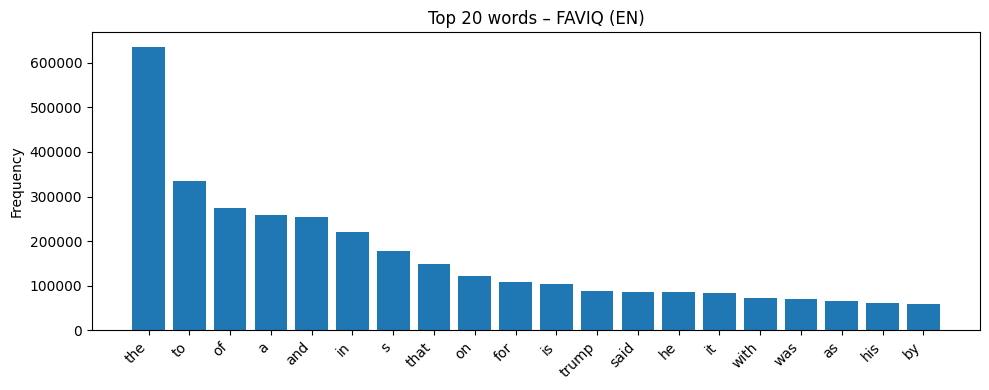

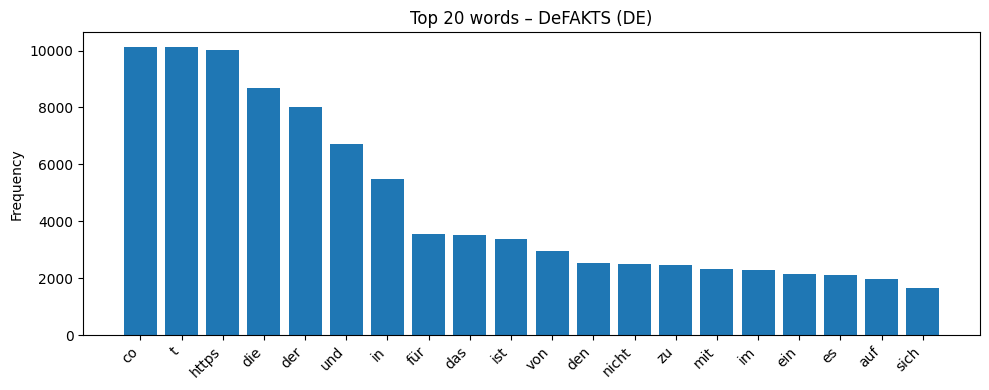

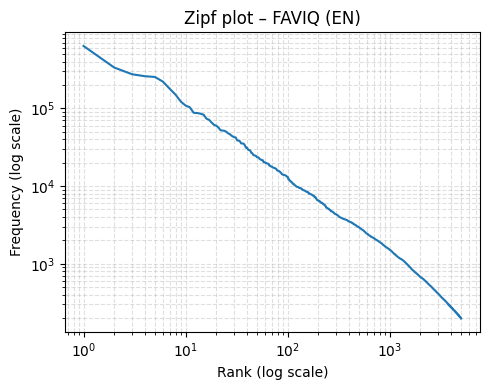

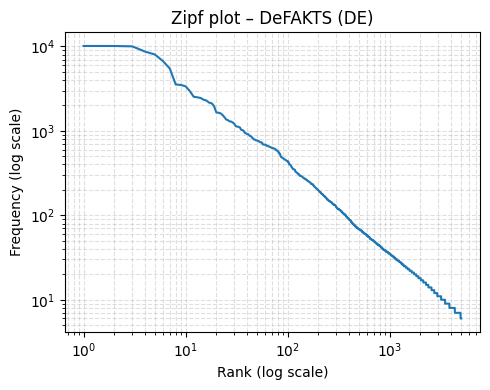

In [36]:
# word counts on TRAIN
faviq_counts   = collect_word_counts(faviq_model,   split="train")
defakts_counts = collect_word_counts(deFakts_model, split="train")

# top words
plot_top_words(faviq_counts,   "FAVIQ (EN)",   k=20)
plot_top_words(defakts_counts, "DeFAKTS (DE)", k=20)

# Zipf curves (rank–frequency)
plot_zipf(faviq_counts,   "FAVIQ (EN)")
plot_zipf(defakts_counts, "DeFAKTS (DE)")


### Zipf's Law without Stopwords!
Let's see what we would be getting if we removed stopwords in both languages!

In [37]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

stopwords_en = set(stopwords.words('english'))
stopwords_de = set(stopwords.words('german'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [38]:
from collections import Counter
import re

WORD_PATTERN = re.compile(r"\w+", flags=re.UNICODE)

def collect_word_counts_no_stopwords(hf_ds, split="train", language="en"):
    """
    Count words in dataset splits while removing stopwords

    language: "en" or "de".
    """
    if language == "en":
        stop = stopwords_en
    elif language == "de":
        stop = stopwords_de
    else:
        stop = set()

    texts = hf_ds[split]["text"]
    counter = Counter()

    for text in texts:
        if not isinstance(text, str):
            continue

        tokens = WORD_PATTERN.findall(text.lower())
        tokens = [t for t in tokens if t not in stop]   # REMOVE STOPWORDS
        counter.update(tokens)

    return counter


PLOTTING


In [39]:
def plot_top_words(counter, dataset_name: str, k=20):
    most_common = counter.most_common(k)
    words = [w for w, _ in most_common]
    freqs = [c for _, c in most_common]

    plt.figure(figsize=(10, 4))
    plt.bar(words, freqs)
    plt.xticks(rotation=45, ha="right")
    plt.ylabel("Frequency")
    plt.title(f"Top {k} content words – {dataset_name}")
    plt.tight_layout()
    plt.show()

def plot_zipf(counter, dataset_name: str, max_rank=5000):
    freqs = np.array(sorted(counter.values(), reverse=True))
    ranks = np.arange(1, len(freqs) + 1)

    if max_rank is not None:
        freqs = freqs[:max_rank]
        ranks = ranks[:max_rank]

    plt.figure(figsize=(5,4))
    plt.loglog(ranks, freqs)
    plt.xlabel("Rank (log scale)")
    plt.ylabel("Frequency (log scale)")
    plt.title(f"Zipf plot (no stopwords) – {dataset_name}")
    plt.grid(True, which="both", ls="--", alpha=0.4)
    plt.tight_layout()
    plt.show()



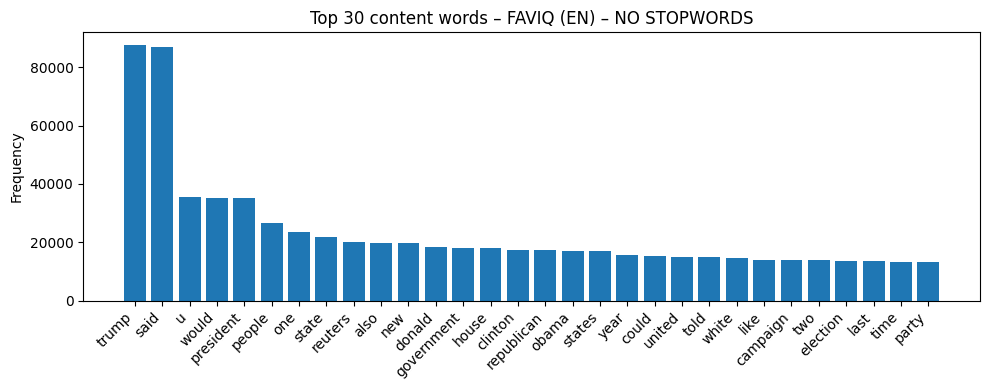

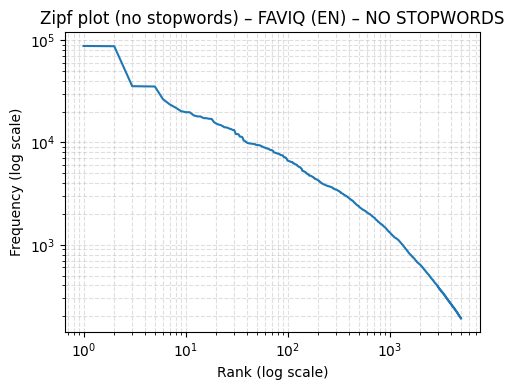

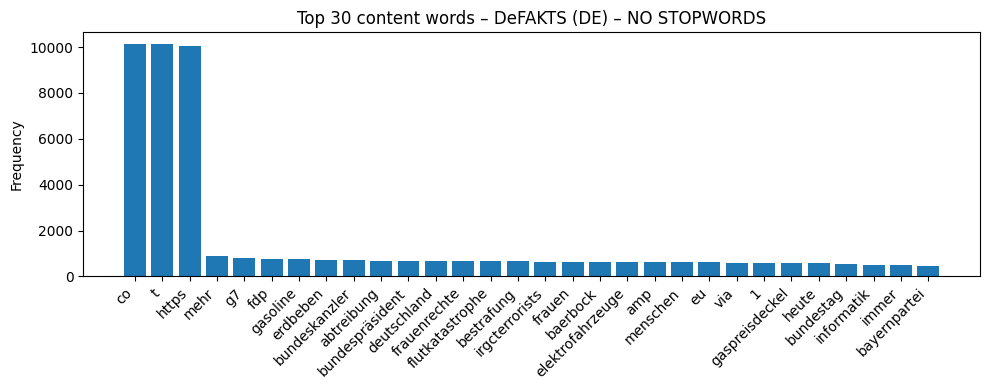

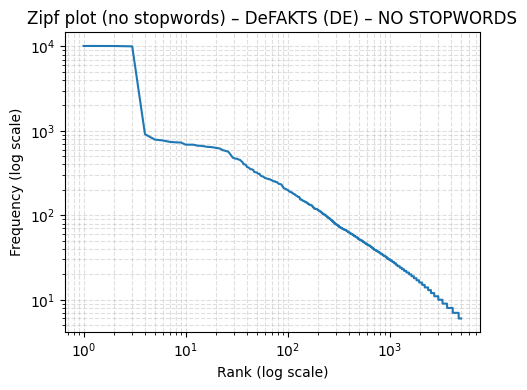

In [40]:
# English: FAVIQ
faviq_counts_no_sw = collect_word_counts_no_stopwords(
    faviq_model, split="train", language="en"
)

plot_top_words(faviq_counts_no_sw, "FAVIQ (EN) – NO STOPWORDS", k=30)
plot_zipf(faviq_counts_no_sw, "FAVIQ (EN) – NO STOPWORDS")

# German: DeFAKTS
defakts_counts_no_sw = collect_word_counts_no_stopwords(
    deFakts_model, split="train", language="de"
)

plot_top_words(defakts_counts_no_sw, "DeFAKTS (DE) – NO STOPWORDS", k=30)
plot_zipf(defakts_counts_no_sw, "DeFAKTS (DE) – NO STOPWORDS")


### ⛓️‍💥Per Label Zipf's Law with no stopwords
Let's look at the distribution of words per a label - we will look at the distribution of the words for the true and false claims to see if we are able to notice pattern of words.

In [41]:
from collections import Counter
import re

WORD_PATTERN = re.compile(r"\w+", flags=re.UNICODE)

def word_counts_by_label(hf_ds, split="train", language="en"):
    """
    Returns two Counters:
      - counter_true  for label == 1
      - counter_false for label == 0
    Stopwords are removed based on language ("en" or "de").
    """
    if language == "en":
        stop = stopwords_en
    else:
        stop = stopwords_de

    texts = hf_ds[split]["text"]
    labels = hf_ds[split]["label"]

    counter_true = Counter()
    counter_false = Counter()

    for text, label in zip(texts, labels):
        if not isinstance(text, str):
            continue

        tokens = WORD_PATTERN.findall(text.lower())
        tokens = [t for t in tokens if t not in stop]

        if label == 1:
            counter_true.update(tokens)
        elif label == 0:
            counter_false.update(tokens)

    return counter_true, counter_false


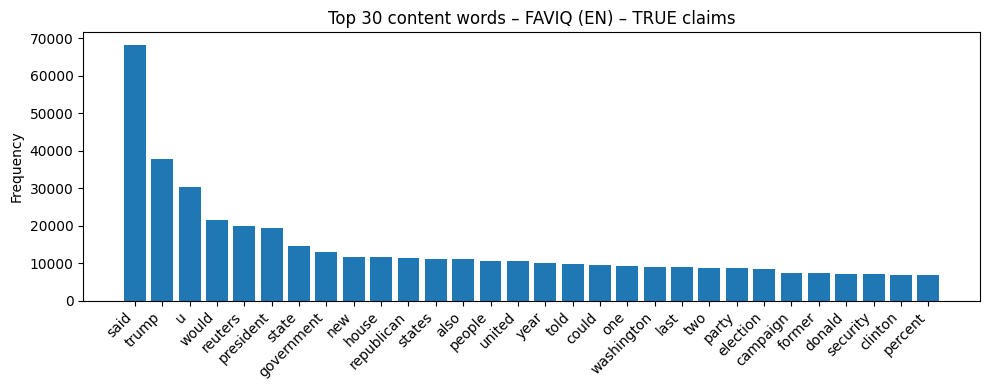

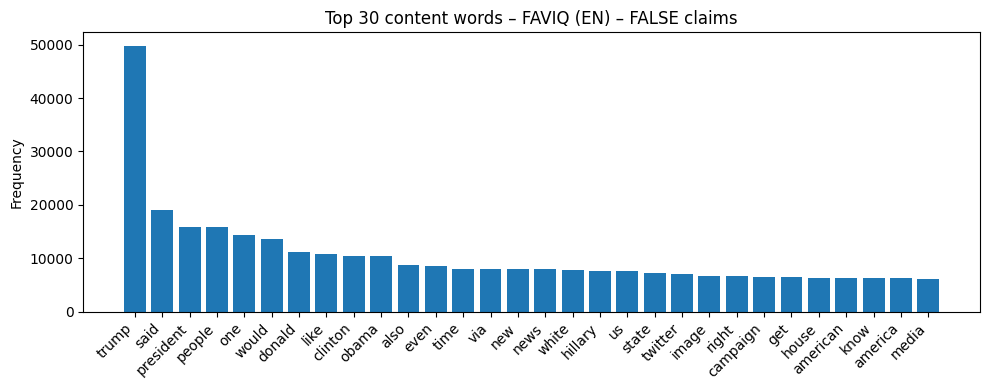

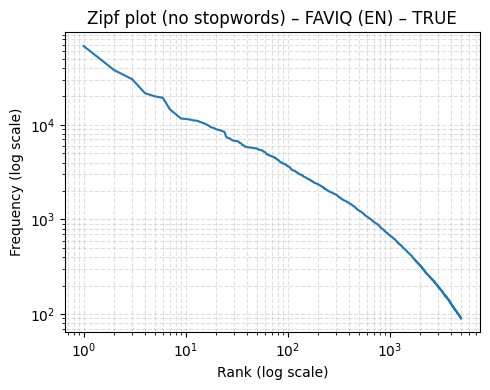

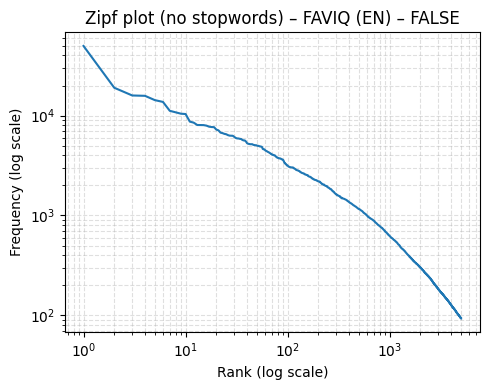

In [42]:
faviq_true, faviq_false = word_counts_by_label(
    faviq_model, split="train", language="en"
)

# Top words
plot_top_words(faviq_true,  "FAVIQ (EN) – TRUE claims",  k=30)
plot_top_words(faviq_false, "FAVIQ (EN) – FALSE claims", k=30)

# Zipf curves
plot_zipf(faviq_true,  "FAVIQ (EN) – TRUE")
plot_zipf(faviq_false, "FAVIQ (EN) – FALSE")


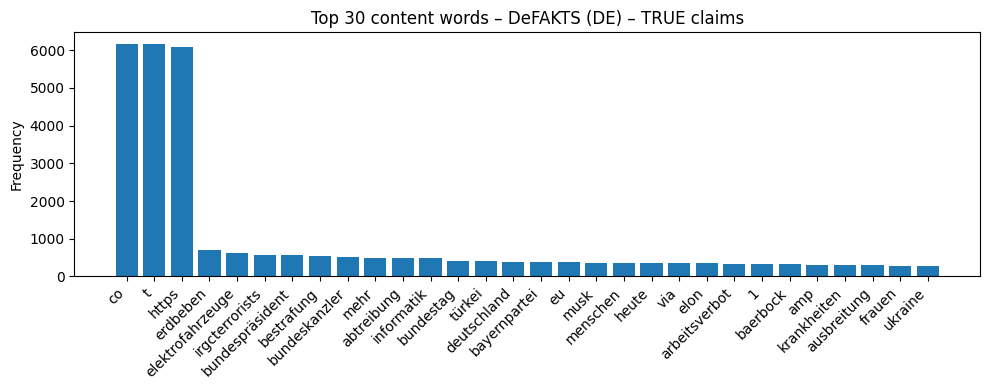

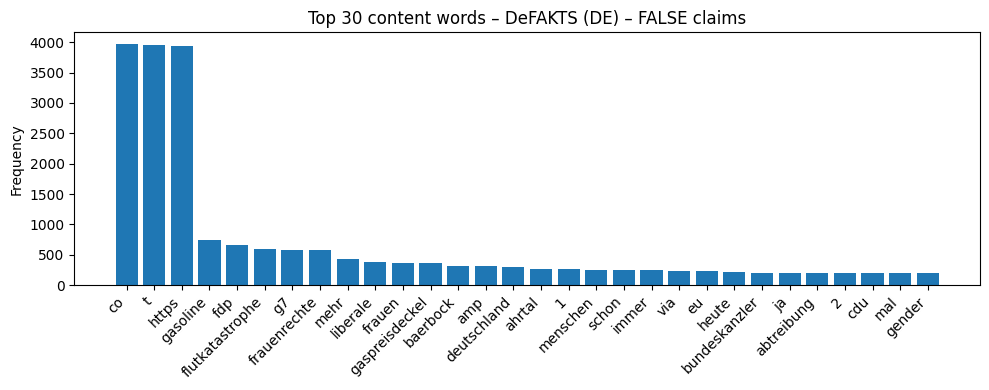

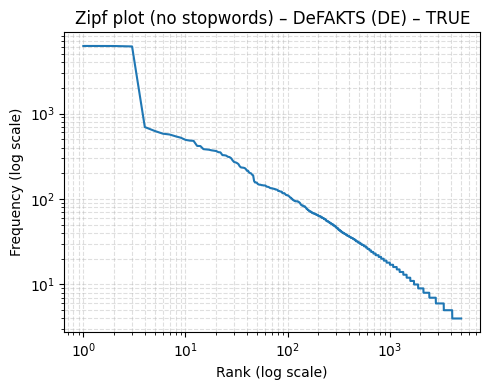

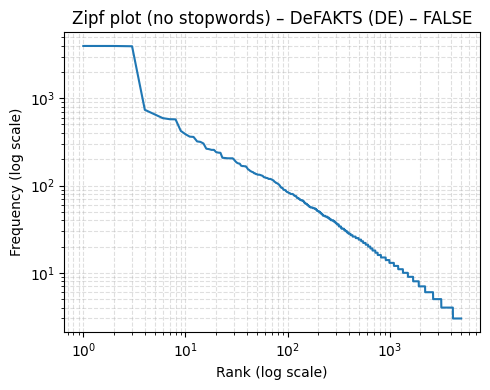

In [43]:
defakts_true, defakts_false = word_counts_by_label(
    deFakts_model, split="train", language="de"
)

plot_top_words(defakts_true,  "DeFAKTS (DE) – TRUE claims",  k=30)
plot_top_words(defakts_false, "DeFAKTS (DE) – FALSE claims", k=30)

plot_zipf(defakts_true,  "DeFAKTS (DE) – TRUE")
plot_zipf(defakts_false, "DeFAKTS (DE) – FALSE")


As we can observe from the graphs above, that the English and German datasets are very different lexically. We believe that those difference will really impact their performance with each language.

*   The distribution of words for DeFAKTS between both labels is a lot more varied than for the english dataset.


**FAVIQ**

👉 The distribution of words for the FAVIQ dataset is nearly the same across both the true and false classes.

👉 The most frequent words in for both labels appear in almost the same order, meaning that they have practically the same frequencies. We see that the words frequencies do not differ between the true and false labels.

👉 True and False are sharing practically the same vocabulary. Therefore, we could say that the dataset had little to no lexical separtion between the true and false labels.

👉 We believe that learning a pattern from this dataset will be much harder than with the German one.

⭐️ Because of this we expect to get a pretty low performance on all our models on the FAVIQ dataset. We hypothesise that the models will have an important difficulty of generalizing and making accurate assumption with the English dataset at it seems like there aren't enough semantic differences between the true and false labels.



**DeFAKTS**

👉 In the german dataset we observe a good difference between the vocabulary used in true VS false claim.

👉 **FALSE claims** contain words that are usually used in a political contexes, ideological issues, controversial and emotionnaly charged topics. We believe that the following words can be used in very discriminative contexts, thus it might be easier to make conclustion using the German dataset.

We also feel like that a lot of the terms found in this list can also induce controversial and polorized opinions.


*   gasoline
*   ruckkatastrophe
*   fdp (free democratic party)
*   afd (alternative for germany => political party)
*   gender
*   frauenrechte (women’s rights)
*   gaspreise (gas prices)
*   abtreibung (abortion)

👉 **TRUE claims** in this dataset have words that can be associated with a neutral informational contents, and used in admnistrative and governmental contexts.


Meaning that they are usuallly less discriminative and less polarizing than the words we have found in the FALSE label.
*   bundespräsident (federal president)
*   bundeskanzler (federal chancellor
*   informatik (computer science)
*   bundestag (federal assembly)
*   eu (Europeean Union)
*   menschen (people)
*   heute (today)
*   ukraine

⭐️ We expect to be able have a pretty good performance with the German dataset as there is a pretty good difference between the voca








# 🎲 Naive Bayes Approach

Let's now create two separate Naive Bayes classifiers Faviq (EN) and DeFakts (DE). Here, we will be taking into consideration the specifics of each of the languages.

We will here be using TF-IDF. We will be using stemmers from Snowball/nltk library

In [44]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, accuracy_score

import numpy as np
import re

# for stemming
!pip install nltk

import nltk
from nltk.stem import SnowballStemmer
nltk.download('punkt')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

##🫆 Removing Stopwords from the datasets for Naive Bayes!
After seeing the results we have gotten with Zipf's law - we have decided that it would be relevant to remove the stopwords all together from the datasets for the Naive Bayes model.
By removing the stopwords we believe that we might be able to have a cleaner and more representative performance as the words that will be kepts are words that 'meaningful' compared to stop words.

In [45]:
import nltk
from nltk.corpus import stopwords
nltk.download("stopwords")

stopwords_en = set(stopwords.words("english"))
stopwords_de = set(stopwords.words("german"))

def remove_stopwords_ds(example, language="en"):
    """
  Return a new 'text' field with stopwords removed - USED ONLY FOR NAIVE BAYES!

    """
    if language == "en":
        stop = stopwords_en
    else:
        stop = stopwords_de

    text = example["text"]

    # safety: handle missing or non-string
    if not isinstance(text, str):
        return {"text": ""}

    # text is already cleaned + lowercased in your pipeline,
    # so simple split is fine
    tokens = text.split()
    tokens = [t for t in tokens if t not in stop]

    return {"text": " ".join(tokens)}


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Removing the stopwords from the Dataset!

In [46]:
from functools import partial

# English – FAVIQ for Naive Bayes (no stopwords)
faviq_nb = faviq_model.map(
    partial(remove_stopwords_ds, language="en")
)

# German – DeFAKTS for Naive Bayes (no stopwords)
deFakts_nb = deFakts_model.map(
    partial(remove_stopwords_ds, language="de")
)

print(faviq_nb["train"][0])
print(deFakts_nb["train"][0])


Map:   0%|          | 0/28025 [00:00<?, ? examples/s]

Map:   0%|          | 0/4366 [00:00<?, ? examples/s]

Map:   0%|          | 0/8587 [00:00<?, ? examples/s]

Map:   0%|          | 0/13904 [00:00<?, ? examples/s]

Map:   0%|          | 0/1986 [00:00<?, ? examples/s]

Map:   0%|          | 0/4089 [00:00<?, ? examples/s]

{'text': 'wow! fantastic! highly recommend entire video: office management budgets omb director mick mulvaney outlines structure, intents purposes trump administration fiscal year 2018 budget taxpayers budget best part great news conference reporter asks cuts climate science programs : 17:00 mark mick mulvaney rips reporter awesome!we recommend entire video see trump hired one smart cookie! mick mulvaney knows budget handles press beautifully!', 'label': 0}
{'label': 0, 'text': 'abtreibung 13ten wo. gleichbedeutend mord! wer danach abtreibt mörder verurteilt werden.'}


🗡️ Let's start with the language-spefic stemming + tokenization!!

In [47]:
def make_stem_tokenizer(language: str, use_stemming: bool = True):
    """
    Returns a tokenizer function for TfidfVectorizer.

    language: 'english' or 'german'
    use_stemming: if True, apply Snowball stemming; otherwise just split.
    """
    # decide which stemmer to use
    stemmer = SnowballStemmer(language) if use_stemming else None

    def tokenizer(text):
        # split on whitespace
        tokens = text.split()

        # optional stemming
        if stemmer is not None:
            tokens = [stemmer.stem(t) for t in tokens]

        return tokens

    return tokenizer


###Current Hyperameter Breakdown for the Baseline Run

**language: str** 👉 Indicates to the stemmer which language should be used.

**use_stemming: bool = True** 👉 Indicates if we should be doing language specific stemming

**ngram_range (1,2)** 👉 Controls which n-grams TF-IDF uses as features. (1,2) indicates to use as features unigrams and bigrams.

**min_df=5**
👉 Drop tokens that appears in fewer than 5 documents in the training split.This applies to extremely rare words/hapax-like items.

**max_df=0.9**
👉 Drop tokens that appears in more than 90% of documents in the training split.

**alpha = 0.1** 👉 Laplace smoothign for MultinominalNB. Controls how much probability mass we are adding to avoid having zero in calculations.

**fit_prior** = True 👉 If this parameter is set to True, the class priors will be learned from the training data. If set to False, we are assiming to have uniform priors, meaning that each class is equally likely, regardless of frequency. Since here our datasets are pretty balanced, we could set the fit_prior to False.

In [48]:
def make_nb_pipeline(language: str,
                     use_stemming: bool = True,
                     ngram_range=(1,2),
                     min_df=5,
                     max_df=0.9,
                     alpha=0.1,
                     fit_prior=True):

  """
  Creates a Tf-IDF + Multinomial Naive Bayes pipeline for each language
  """

  tokenizer = make_stem_tokenizer(language, use_stemming=use_stemming)

  tfidf_vectorizer = TfidfVectorizer(
      tokenizer=tokenizer,
      preprocessor=None,  # <-- not "processor"
      lowercase=False,    # we already lowercased earlier
      ngram_range=ngram_range,
      min_df=min_df, # so we are removing words at polar extremes
      max_df=max_df # so we are removing words at polar extremes
  )

  nb_classifier = MultinomialNB(
      alpha=alpha,
      fit_prior=fit_prior
  )

  pipe = Pipeline([
      ('tfidf', tfidf_vectorizer),
      ('nb', nb_classifier)
  ])

  return pipe


Training + Evaluating on train/validation/test sets

In [49]:
def run_nb_for_dataset (hf_ds,
                        language_name: str,
                        sklearn_language: str,
                        use_stemming: bool = True,
                        alpha = 1.0,
                        ngram_range=(1,2),
                        min_df=5,
                        max_df=0.9):

  """
  hf_fd => Hugging face DatasetDict with train, validation and test with the claim and labels
  language_name => for printing either EN or DE
  sklearn_language => for SnowballStemmer (english, german)
  """


  print(f"\n====================================")
  print(f" Naive Bayes for {language_name}")
  print(f"====================================")

  # DATA SPLITS
  x_train = hf_ds["train"]["text"]
  y_train = hf_ds["train"]["label"]

  x_val = hf_ds["validation"]["text"]
  y_val = hf_ds["validation"]["label"]

  x_test = hf_ds["test"]["text"]
  y_test = hf_ds["test"]["label"]

  # building the pipeline
  model = make_nb_pipeline(
      language = sklearn_language,
      use_stemming = use_stemming,
      ngram_range = ngram_range,
      min_df =min_df,
      max_df = max_df,
      alpha = alpha,
      fit_prior= True
  )

  # fitting the model on TRAIN
  print("\nFitting model on TRAINING...")
  model.fit(x_train, y_train)

  # Evaluate on VALIDATION
  print("\n--- VALIDATION RESULTS ---")
  val_preds = model.predict(x_val)

  print("Accuracy:", accuracy_score(y_val, val_preds))
  print("\nClassification report (validation):")
  print(classification_report(y_val, val_preds, digits=4))

  # Evaluate on TEST
  print("\n--- TEST RESULTS ---")
  test_preds = model.predict(x_test)
  print("Accuracy:", accuracy_score(y_test, test_preds))
  print("\nClassification report (test):")
  print(classification_report(y_test, test_preds, digits=4))

  return model



Running the Naive Bayes Classifier for the English and German!!

In [50]:
# English: FAVIQ
nb_en = run_nb_for_dataset(
    faviq_nb,
    language_name="English (FAVIQ)",
    sklearn_language="english",
    use_stemming=True,        # set to False if stemming causes issues
    alpha=1.0,
    ngram_range=(1, 2),
    min_df=5,
    max_df=0.9,
)

# German: DeFAKTS
nb_de = run_nb_for_dataset(
    deFakts_nb,
    language_name="German (DeFAKTS)",
    sklearn_language="german",
    use_stemming=True,
    alpha=1.0,
    ngram_range=(1, 2),
    min_df=5,
    max_df=0.9,
)



 Naive Bayes for English (FAVIQ)

Fitting model on TRAINING...


/usr/local/lib/python3.12/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(



--- VALIDATION RESULTS ---
Accuracy: 0.9578561612459917

Classification report (validation):
              precision    recall  f1-score   support

           0     0.9714    0.9452    0.9581      2228
           1     0.9445    0.9710    0.9576      2138

    accuracy                         0.9579      4366
   macro avg     0.9579    0.9581    0.9579      4366
weighted avg     0.9582    0.9579    0.9579      4366


--- TEST RESULTS ---
Accuracy: 0.9606381739839291

Classification report (test):
              precision    recall  f1-score   support

           0     0.9734    0.9478    0.9605      4331
           1     0.9483    0.9737    0.9608      4256

    accuracy                         0.9606      8587
   macro avg     0.9609    0.9608    0.9606      8587
weighted avg     0.9610    0.9606    0.9606      8587


 Naive Bayes for German (DeFAKTS)

Fitting model on TRAINING...


/usr/local/lib/python3.12/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(



--- VALIDATION RESULTS ---
Accuracy: 0.8006042296072508

Classification report (validation):
              precision    recall  f1-score   support

           0     0.8102    0.6683    0.7324       811
           1     0.7957    0.8919    0.8411      1175

    accuracy                         0.8006      1986
   macro avg     0.8030    0.7801    0.7868      1986
weighted avg     0.8016    0.8006    0.7967      1986


--- TEST RESULTS ---
Accuracy: 0.7945707997065297

Classification report (test):
              precision    recall  f1-score   support

           0     0.7769    0.6763    0.7231      1622
           1     0.8039    0.8723    0.8367      2467

    accuracy                         0.7946      4089
   macro avg     0.7904    0.7743    0.7799      4089
weighted avg     0.7932    0.7946    0.7917      4089



##Naive Bayes Baseline Experiment Result

From above, we can observe that the German dataset is performing much better than the English one. We have some hypothesis that we would like to test out on why we are currently getting such results.

*  From an informational perspective, this could be happening because in the Faviq dataset we have a smaller average of words (≈10.7) per an instance while with DeFakts we have an average that is much higher (≈25.5) words. This could mean that we could have more ease discerning true from false in DE since we have more lexical cues while the EN dataset has much less evidence.
* The current data processing done could be affecting more the english dataset than the german one, it might be currently getting rid of too many indicators that tell whether a claim that is true/false, especially considering that the type and the source of the data from both file are different.
* Stemming could also be affecting both languages differently - we test this hypothesis in the next run. In german, the stemming could be helpful while harmful for the english data.

###🚫 Baseline run NB with no stemming!

In this run, stemming will not be applied to both languages to observe how it affects both their performances.

In [51]:
print("HERE WE ARE OBSERVING THE PERFORMANCE OF NAIVE BAYES ON BOTH DATASETS WITHOUT STEMMING!\n")

# English: FAVIQ - no stemming
nb_en = run_nb_for_dataset(
    faviq_nb,
    language_name="English (FAVIQ)",
    sklearn_language="english",
    use_stemming = False,
    alpha=1.0,
    ngram_range=(1, 2),
    min_df=5,
    max_df=0.9,
)

# German: DeFAKTS - no stemming
nb_de = run_nb_for_dataset(
    deFakts_nb,
    language_name ="German (DeFAKTS)",
    sklearn_language ="german",
    use_stemming = False,
    alpha=1.0,
    ngram_range=(1, 2),
    min_df=5,
    max_df=0.9,
)

HERE WE ARE OBSERVING THE PERFORMANCE OF NAIVE BAYES ON BOTH DATASETS WITHOUT STEMMING!


 Naive Bayes for English (FAVIQ)

Fitting model on TRAINING...


/usr/local/lib/python3.12/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(



--- VALIDATION RESULTS ---
Accuracy: 0.9590013742556115

Classification report (validation):
              precision    recall  f1-score   support

           0     0.9710    0.9479    0.9593      2228
           1     0.9471    0.9705    0.9587      2138

    accuracy                         0.9590      4366
   macro avg     0.9590    0.9592    0.9590      4366
weighted avg     0.9593    0.9590    0.9590      4366


--- TEST RESULTS ---
Accuracy: 0.9625014556888319

Classification report (test):
              precision    recall  f1-score   support

           0     0.9742    0.9508    0.9624      4331
           1     0.9511    0.9744    0.9626      4256

    accuracy                         0.9625      8587
   macro avg     0.9627    0.9626    0.9625      8587
weighted avg     0.9628    0.9625    0.9625      8587


 Naive Bayes for German (DeFAKTS)

Fitting model on TRAINING...


/usr/local/lib/python3.12/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(



--- VALIDATION RESULTS ---
Accuracy: 0.8096676737160121

Classification report (validation):
              precision    recall  f1-score   support

           0     0.8207    0.6831    0.7456       811
           1     0.8040    0.8970    0.8479      1175

    accuracy                         0.8097      1986
   macro avg     0.8124    0.7901    0.7968      1986
weighted avg     0.8108    0.8097    0.8062      1986


--- TEST RESULTS ---
Accuracy: 0.7967718268525312

Classification report (test):
              precision    recall  f1-score   support

           0     0.7819    0.6763    0.7253      1622
           1     0.8045    0.8760    0.8387      2467

    accuracy                         0.7968      4089
   macro avg     0.7932    0.7761    0.7820      4089
weighted avg     0.7956    0.7968    0.7937      4089



From the cell above, we proves that stemming has very little effect on the performance of the Naive Bayes implementation for both languages. We can observe that the results for both languages are practically the same with and without stemming.

Therefore, we can conclude that the cause of the english dataset's poor performance is not due to the word stemming rather the lack of variety in the most frequent words in the true and false labels.

### Naive Bayes Performance: With vs. Without Stemming


🇬🇧 Naive Bayes - FAVIQ (english)
| Variant        | Validation F1 | Test F1    |
| -------------------- | ------------- | ---------- |
| **With stemming**    | **0.4269**    | **0.4283** |
| **Without stemming** | **0.4228**        | **0.4250**     |

🇩🇪 Naive Bayes - DeFAKTS
| Variant        | Validation F1 | Test F1    |
| -------------------- | ------------- | ---------- |
| **With stemming**    | **0.7868**    | **0.7799** |
| **Without stemming** | **0.7968**    | **0.7820** |




###😳 Performance is still not increasing the for english dataset.

Since claims with the English dataset have an average length that is much smaller than the German one, maybe decreasing the min_df to 3 will help the performance. We will also be using stemming for this run. This way we may be able to keep more 'rare' words that may be more discriminative. Let's test this out...

In [52]:
print("HERE WE ARE OBSERVING THE PERFORMANCE OF NAIVE BAYES ON BOTH DATASETS WITH MIN_DF=3!\n")

# English: FAVIQ
nb_en = run_nb_for_dataset(
    faviq_nb,
    language_name="English (FAVIQ)",
    sklearn_language="english",
    use_stemming = True,
    alpha=1.0,
    ngram_range=(1, 2),
    min_df=3,
    max_df=0.9,
)

# German: DeFAKTS - no stemming
nb_de = run_nb_for_dataset(
    deFakts_nb,
    language_name ="German (DeFAKTS)",
    sklearn_language ="german",
    use_stemming = True,
    alpha=1.0,
    ngram_range=(1, 2),
    min_df=3,
    max_df=0.9,
)

HERE WE ARE OBSERVING THE PERFORMANCE OF NAIVE BAYES ON BOTH DATASETS WITH MIN_DF=3!


 Naive Bayes for English (FAVIQ)

Fitting model on TRAINING...


/usr/local/lib/python3.12/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(



--- VALIDATION RESULTS ---
Accuracy: 0.9573980760421439

Classification report (validation):
              precision    recall  f1-score   support

           0     0.9789    0.9367    0.9573      2228
           1     0.9369    0.9790    0.9575      2138

    accuracy                         0.9574      4366
   macro avg     0.9579    0.9578    0.9574      4366
weighted avg     0.9583    0.9574    0.9574      4366


--- TEST RESULTS ---
Accuracy: 0.960055898451147

Classification report (test):
              precision    recall  f1-score   support

           0     0.9798    0.9402    0.9596      4331
           1     0.9415    0.9803    0.9605      4256

    accuracy                         0.9601      8587
   macro avg     0.9607    0.9602    0.9601      8587
weighted avg     0.9608    0.9601    0.9600      8587


 Naive Bayes for German (DeFAKTS)

Fitting model on TRAINING...


/usr/local/lib/python3.12/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(



--- VALIDATION RESULTS ---
Accuracy: 0.8041289023162135

Classification report (validation):
              precision    recall  f1-score   support

           0     0.8318    0.6523    0.7312       811
           1     0.7911    0.9089    0.8459      1175

    accuracy                         0.8041      1986
   macro avg     0.8114    0.7806    0.7886      1986
weighted avg     0.8077    0.8041    0.7991      1986


--- TEST RESULTS ---
Accuracy: 0.7997065297138665

Classification report (test):
              precision    recall  f1-score   support

           0     0.7999    0.6603    0.7234      1622
           1     0.7996    0.8914    0.8430      2467

    accuracy                         0.7997      4089
   macro avg     0.7997    0.7758    0.7832      4089
weighted avg     0.7997    0.7997    0.7956      4089



| Dataset              | Validation F1 | Test F1    |
| -------------------- | ------------- | ---------- |
| **English – FAVIQ**  | **0.4010**    | **0.4001** |
| **German – DeFAKTS** | **0.7886**    | **0.7832** |


Our hypothesis was wrong! By decreasing the min_df=3 we are actually observing a performance decrease for the english dataset and a slight increase for the german.

Therefore, allowing more rare words did not help with the Faviq, but had a small postive impact on DeFAKTS.

This again supports our claim that the DeFAKTS dataset has a vocabulary that is more discriminative thus making it easier to predict the labels with.




After decreasing *min_df* from 5 to 3, we observe that we obtain a worse performance for the English dataset. What if we increase **min_df=7** would be observe a positive or negative change in the performance?

We believe that by doing so we could observe an increase as here we would be keeping words we have more data on, since we would be keeping words we have more evidence on! Let's see!

In [53]:
print("HERE WE ARE OBSERVING THE PERFORMANCE OF NAIVE BAYES ON BOTH DATASETS WITH MIN_DF=7!\n")

# English: FAVIQ
nb_en = run_nb_for_dataset(
    faviq_nb,
    language_name="English (FAVIQ)",
    sklearn_language="english",
    use_stemming = True,
    alpha=1.0,
    ngram_range=(1, 2),
    min_df=7,
    max_df=0.9,
)

# German: DeFAKTS - no stemming
nb_de = run_nb_for_dataset(
    deFakts_nb,
    language_name ="German (DeFAKTS)",
    sklearn_language ="german",
    use_stemming = True,
    alpha=1.0,
    ngram_range=(1, 2),
    min_df=7,
    max_df=0.9,
)

HERE WE ARE OBSERVING THE PERFORMANCE OF NAIVE BAYES ON BOTH DATASETS WITH MIN_DF=7!


 Naive Bayes for English (FAVIQ)

Fitting model on TRAINING...


/usr/local/lib/python3.12/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(



--- VALIDATION RESULTS ---
Accuracy: 0.9573980760421439

Classification report (validation):
              precision    recall  f1-score   support

           0     0.9688    0.9470    0.9578      2228
           1     0.9461    0.9682    0.9570      2138

    accuracy                         0.9574      4366
   macro avg     0.9574    0.9576    0.9574      4366
weighted avg     0.9577    0.9574    0.9574      4366


--- TEST RESULTS ---
Accuracy: 0.9605217188773728

Classification report (test):
              precision    recall  f1-score   support

           0     0.9705    0.9506    0.9605      4331
           1     0.9507    0.9706    0.9606      4256

    accuracy                         0.9605      8587
   macro avg     0.9606    0.9606    0.9605      8587
weighted avg     0.9607    0.9605    0.9605      8587


 Naive Bayes for German (DeFAKTS)

Fitting model on TRAINING...


/usr/local/lib/python3.12/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(



--- VALIDATION RESULTS ---
Accuracy: 0.8061430010070494

Classification report (validation):
              precision    recall  f1-score   support

           0     0.8142    0.6806    0.7414       811
           1     0.8020    0.8928    0.8449      1175

    accuracy                         0.8061      1986
   macro avg     0.8081    0.7867    0.7932      1986
weighted avg     0.8070    0.8061    0.8027      1986


--- TEST RESULTS ---
Accuracy: 0.7906578625580827

Classification report (test):
              precision    recall  f1-score   support

           0     0.7675    0.6776    0.7197      1622
           1     0.8032    0.8650    0.8329      2467

    accuracy                         0.7907      4089
   macro avg     0.7853    0.7713    0.7763      4089
weighted avg     0.7890    0.7907    0.7880      4089



🎉 Our hypothesis was half right!


📊 **Naive Bayes (min_df = 7) — F1 Score Comparison**

**English - Faviq**
| Split          | F1-score (Class 0) | F1-score (Class 1) | **Macro F1** |
| -------------- | ------------------ | ------------------ | ------------ |
| **Validation** | 0.4742             | 0.4093             | **0.4418**   |
| **Test**       | 0.4756             | 0.4079             | **0.4418**   |



**German - DeFAKTS**
| Split          | F1-score (Class 0) | F1-score (Class 1) | **Macro F1** |
| -------------- | ------------------ | ------------------ | ------------ |
| **Validation** | 0.7414             | 0.8449             | **0.7932**   |
| **Test**       | 0.7197             | 0.8329             | **0.7763**   |


We do observe a small increase of performance for the Faviq dataset compare to the baseline run with min_df=5. It shows that keeping words that appear in at least 7 documents is helping improve the performance of the model, this might be because it now relies on better supported words and on less noise.

However, the performance with the DeFakts dataset is minimally  worse than the run with min_df=5. This shows that the DeFakts datasets was already all the signal needed to have a good performance with min_df=5, so increasing it to 7 is useless for it.



## Logistic Regression Classifier

Let's test out if we are able to get an overall better performance using the Logistic Regression classifier. Since logistic regression is made for binary classification our results might improve! Note that we are keeping the same parameters as the baseline run as the MultiNominalNB implementation

 Let's test this out....



In [54]:
from sklearn.linear_model import LogisticRegression

def make_lr_pipeline (language:str,
                      use_stemming: bool = False,
                      ngram_range=(1,2),
                      min_df=5,
                      max_df=0.9,
                      C = 1.0

                      ):


  """
  Creating a TF-IDF + Logistic Regression pipeline for each language
  """

  tokenizer = make_stem_tokenizer(language, use_stemming=use_stemming)

  tfidf_vectorizer = TfidfVectorizer(
      tokenizer=tokenizer,
      preprocessor=None,
      lowercase = False, # already lowercased the whole text
      ngram_range=ngram_range,
      min_df=min_df,
      max_df=max_df
  )

  lr_classifier = LogisticRegression(
      C=C,
      max_iter=1000,
      n_jobs = -1,
      solver = "liblinear", # good for high dimensional and sparse data
      penalty="l2"
      )

  pipe = Pipeline([
    ('tfidf', tfidf_vectorizer),
    ('lr', lr_classifier)
    ])

  return pipe



In [55]:
def run_lr_for_dataset(hf_ds,
                       language_name: str,
                       sklearn_language: str,
                       use_stemming: bool = False,
                       C=1.0,
                       ngram_range=(1, 2),
                       min_df=5,
                       max_df=0.9):
    """
    Train & evaluate TF-IDF + Logistic Regression on a HF DatasetDict.
    """

    print(f"\n====================================")
    print(f" Logistic Regression for {language_name}")
    print(f"====================================")

    # DATA SPLITS
    x_train = hf_ds["train"]["text"]
    y_train = hf_ds["train"]["label"]

    x_val = hf_ds["validation"]["text"]
    y_val = hf_ds["validation"]["label"]

    x_test = hf_ds["test"]["text"]
    y_test = hf_ds["test"]["label"]

    # build the pipeline
    model = make_lr_pipeline(
        language=sklearn_language,
        use_stemming=use_stemming,
        ngram_range=ngram_range,
        min_df=min_df,
        max_df=max_df,
        C=C
    )

    # fit on TRAIN
    print("\nFitting model on TRAINING...")
    model.fit(x_train, y_train)

    # VALIDATION
    print("\n--- VALIDATION RESULTS ---")
    val_preds = model.predict(x_val)
    print("Accuracy:", accuracy_score(y_val, val_preds))
    print("\nClassification report (validation):")
    print(classification_report(y_val, val_preds, digits=4))

    # TEST
    print("\n--- TEST RESULTS ---")
    test_preds = model.predict(x_test)
    print("Accuracy:", accuracy_score(y_test, test_preds))
    print("\nClassification report (test):")
    print(classification_report(y_test, test_preds, digits=4))

    return model


In [56]:
# English: FAVIQ
lr_en = run_lr_for_dataset(
    faviq_nb,
    language_name="English (FAVIQ)",
    sklearn_language="english",
    use_stemming=False,      # with no stemming since little to no impact on both languages
    C=1.0,
    ngram_range=(1, 2),
    min_df=5,
    max_df=0.9,
)

# German: DeFAKTS
lr_de = run_lr_for_dataset(
    deFakts_nb,
    language_name="German (DeFAKTS)",
    sklearn_language="german",
    use_stemming=False,
    C=1.0,
    ngram_range=(1, 2),
    min_df=5,
    max_df=0.9,
)



 Logistic Regression for English (FAVIQ)

Fitting model on TRAINING...


/usr/local/lib/python3.12/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  warnings.warn(



--- VALIDATION RESULTS ---
Accuracy: 0.9871736142922584

Classification report (validation):
              precision    recall  f1-score   support

           0     0.9932    0.9816    0.9874      2228
           1     0.9811    0.9930    0.9870      2138

    accuracy                         0.9872      4366
   macro avg     0.9871    0.9873    0.9872      4366
weighted avg     0.9872    0.9872    0.9872      4366


--- TEST RESULTS ---
Accuracy: 0.9896354955164784

Classification report (test):
              precision    recall  f1-score   support

           0     0.9939    0.9855    0.9897      4331
           1     0.9853    0.9939    0.9896      4256

    accuracy                         0.9896      8587
   macro avg     0.9896    0.9897    0.9896      8587
weighted avg     0.9897    0.9896    0.9896      8587


 Logistic Regression for German (DeFAKTS)

Fitting model on TRAINING...


/usr/local/lib/python3.12/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  warnings.warn(



--- VALIDATION RESULTS ---
Accuracy: 0.824269889224572

Classification report (validation):
              precision    recall  f1-score   support

           0     0.8300    0.7164    0.7690       811
           1     0.8212    0.8987    0.8582      1175

    accuracy                         0.8243      1986
   macro avg     0.8256    0.8076    0.8136      1986
weighted avg     0.8248    0.8243    0.8218      1986


--- TEST RESULTS ---
Accuracy: 0.8153582783076547

Classification report (test):
              precision    recall  f1-score   support

           0     0.8004    0.7121    0.7537      1622
           1     0.8235    0.8833    0.8523      2467

    accuracy                         0.8154      4089
   macro avg     0.8120    0.7977    0.8030      4089
weighted avg     0.8143    0.8154    0.8132      4089



### Comparison of Naive Bayes and Logistic Regression (TF–IDF, no stemming)

ENGLISH - FAVIQ
| Model                         | Validation F1 | Test F1    |
| ----------------------------- | ------------- | ---------- |
| **Logistic Regression**       | **0.4440**    | **0.4411** |
| **Naive Bayes (no stemming)** | **0.4228**    | **0.4250** |


GERMAN - DEFAKTS
| Model                         | Validation F1 | Test F1    |
| ----------------------------- | ------------- | ---------- |
| **Logistic Regression**       | **0.8136**    | **0.8030** |
| **Naive Bayes (no stemming)** | **0.7968**    | **0.7820** |


With a Logistic Regression implementation with no stemming we are able to outperform Naive Bayes both datasets.

This shows that overall it is hard to work with the Faviq dataset and bag-of-words models - no matter what the performance seems to remain poor. Even with Logistic Regression we are not able to achieve a better performance with the English dataset, which suggest that its claims are harder to separate with a simple lexical model compared to the DeFakts dataset.


# 🧠 Neural Network




In [57]:
!pip install gensim

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.9/27.9 MB 87.2 MB/s eta 0:00:00


###Word Embedding using fastText pretrained Embeddings

In [58]:
import torch
import numpy as np
from gensim.models import FastText

# 1. Prepare the corpus (Combine English and German training data)
print("Preparing corpus...")
corpus_en = [text.split() for text in faviq_model["train"]["text"]]
corpus_de = [text.split() for text in deFakts_model["train"]["text"]]
full_corpus = corpus_en + corpus_de

print(f"Training FastText on {len(full_corpus)} sentences (EN + DE)...")

# 2. Train FastText model
# vector_size=300 is standard, window=5 looks at 5 words context
ft_model = FastText(vector_size=300, window=5, min_count=3, sentences=full_corpus, epochs=10)

print("FastText training complete.")

# 3. Create Word-to-Index and Embedding Matrix for PyTorch
PAD_TOKEN = "<PAD>"
UNK_TOKEN = "<UNK>"

# Start indices: 0 for padding, 1 for unknown
word_to_index = {PAD_TOKEN: 0, UNK_TOKEN: 1}
for word in ft_model.wv.index_to_key:
    word_to_index[word] = len(word_to_index)

vocab_size = len(word_to_index)
embed_dim = 300

# Initialize embedding matrix with zeros
embedding_matrix = torch.zeros((vocab_size, embed_dim))

# Fill matrix with trained FastText vectors
for word, idx in word_to_index.items():
    if word in ft_model.wv:
        embedding_matrix[idx] = torch.tensor(ft_model.wv[word])
    elif word == UNK_TOKEN:
        # Initialize UNK with random normal distribution
        embedding_matrix[idx] = torch.randn(embed_dim)

print(f"PyTorch Embedding Matrix shape: {embedding_matrix.shape}")

Preparing corpus...
Training FastText on 41929 sentences (EN + DE)...


KeyboardInterrupt: 

### Dataset processing + Creating the model

In [ ]:
import torch.nn as nn
from torch.utils.data import Dataset

# --- Creating a function for data processing
class SentimentTextDataset(Dataset):
    def __init__(self, texts, labels, word_to_index, max_len=64):
        self.texts = texts
        self.labels = labels
        self.word_to_index = word_to_index
        self.max_len = max_len
        self.unk_idx = word_to_index["<UNK>"]

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]

        tokens = text.split()
        # Convert words to indices
        indices = [self.word_to_index.get(w, self.unk_idx) for w in tokens]

        # Truncate or Pad
        if len(indices) > self.max_len:
            indices = indices[:self.max_len]
        padded = indices + [0] * (self.max_len - len(indices))

        return torch.tensor(padded, dtype=torch.long), torch.tensor(label, dtype=torch.long)

# --- Neural Network Model ---
class MultilingualClassifier(nn.Module):
    def __init__(self, embedding_matrix, hidden_dim=256, num_classes=2):
        super().__init__()
        vocab_size, embed_dim = embedding_matrix.shape

        # Load pretrained FastText embeddings
        # padding_idx=0 ensures the PAD token vector stays at 0
        self.embedding = nn.Embedding.from_pretrained(embedding_matrix, freeze=False, padding_idx=0)

        # Layers
        self.fc1 = nn.Linear(embed_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.1)
        self.fc2 = nn.Linear(hidden_dim, num_classes)

    def forward(self, x):
        # x shape: [batch_size, seq_len]

        # 1. Get Embeddings
        embeds = self.embedding(x) # [batch, seq, dim]

        # 2. Average Embedding (ignoring padding)
        mask = (x != 0).float().unsqueeze(-1) # [batch, seq, 1]
        sum_embeds = torch.sum(embeds * mask, dim=1)
        counts = torch.sum(mask, dim=1).clamp(min=1) # Avoid division by zero
        avg_embeds = sum_embeds / counts # [batch, dim]

        # 3. Classifier
        out = self.fc1(avg_embeds)
        out = self.relu(out)
        out = self.dropout(out)
        out = self.fc2(out)
        return out

### Creating an evaluate model function for encapsulation + easy reeuse




In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def evaluate_model(model, dataloader, device):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)

            preds = outputs.argmax(dim=1).cpu().numpy()
            true = labels.cpu().numpy()

            all_preds.extend(preds)
            all_labels.extend(true)

    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average="macro", zero_division=0)
    recall = recall_score(all_labels, all_preds, average="macro", zero_division=0)
    macro_f1 = f1_score(all_labels, all_preds, average="macro")

    return accuracy, precision, recall, macro_f1


### Preparing the Training Dataset

In [ ]:
from torch.utils.data import DataLoader

# 1. Extract 'text' and 'label' from faviq_model train split
eng_train_texts = faviq_model["train"]["text"]
eng_train_labels = faviq_model["train"]["label"]

# 2. Extract 'text' and 'label' from deFakts_model train split
ger_train_texts = deFakts_model["train"]["text"]
ger_train_labels = deFakts_model["train"]["label"]

# 3. Concatenate text lists by converting them to Python lists first
combined_train_texts = list(eng_train_texts) + list(ger_train_texts)

# 4. Concatenate label lists by converting them to Python lists first
combined_train_labels = list(eng_train_labels) + list(ger_train_labels)

# 5. Instantiate SentimentTextDataset
eng_train_dataset = SentimentTextDataset(
    texts=eng_train_texts,
    labels=eng_train_labels,
    word_to_index=word_to_index
)

combined_train_dataset = SentimentTextDataset(
    texts=combined_train_texts,
    labels=combined_train_labels,
    word_to_index=word_to_index
)

combined_train_loader = DataLoader(
    dataset=combined_train_dataset,
    batch_size=8,
    shuffle=True,
    num_workers=2
)

eng_train_loader = DataLoader(
    dataset=eng_train_dataset,
    batch_size=8,
    shuffle=True,
    num_workers=2
)

ger_train_dataset = SentimentTextDataset(

    texts=ger_train_texts,
    labels=ger_train_labels,
    word_to_index=word_to_index
)

# 6. Create DataLoader
ger_train_loader = DataLoader(
    dataset=ger_train_dataset,
    batch_size=8,
    shuffle=True,
    num_workers=2
)

print(f"Combined training dataset size: {len(combined_train_dataset)}")
print(f"Combined training loader batch size: {combined_train_loader.batch_size}")

print(f"eng training dataset size: {len(eng_train_dataset)}")
print(f"eng training loader batch size: {eng_train_loader.batch_size}")

print(f"ger training dataset size: {len(ger_train_dataset)}")
print(f"ger training loader batch size: {ger_train_loader.batch_size}")

### Preparing the validation dataset



In [ ]:
from torch.utils.data import DataLoader

# 1. Extract 'text' and 'label' from faviq_model validation split
faviq_validation_texts = faviq_model["validation"]["text"]
faviq_validation_labels = faviq_model["validation"]["label"]

# 2. Extract 'text' and 'label' from deFakts_model validation split
defakts_validation_texts = deFakts_model["validation"]["text"]
defakts_validation_labels = deFakts_model["validation"]["label"]

# 3. Concatenate text lists by converting them to Python lists first
combined_validation_texts = list(faviq_validation_texts) + list(defakts_validation_texts)

# 4. Concatenate label lists by converting them to Python lists first
combined_validation_labels = list(faviq_validation_labels) + list(defakts_validation_labels)

# 5. Instantiate SentimentTextDataset
combined_validation_dataset = SentimentTextDataset(
    texts=combined_validation_texts,
    labels=combined_validation_labels,
    word_to_index=word_to_index
)
eng_validation_dataset = SentimentTextDataset(
    texts=faviq_validation_texts,
    labels=faviq_validation_labels,
    word_to_index=word_to_index
)
ger_validation_dataset = SentimentTextDataset(
    texts=defakts_validation_texts,
    labels=defakts_validation_labels,
    word_to_index=word_to_index
)
# 6. Create DataLoader
combined_validation_loader = DataLoader(
    dataset=combined_validation_dataset,
    shuffle=True,
    num_workers=2,
    batch_size=8,
)

eng_validation_loader = DataLoader(
    dataset=eng_validation_dataset,
    shuffle=True,
    num_workers=2,
    batch_size=8,
)

ger_validation_loader = DataLoader(
    dataset=ger_validation_dataset,
    shuffle=True,
    num_workers=2,
    batch_size=8,
)

print(f"Combined validation dataset size: {len(combined_validation_dataset)}")
print(f"Combined validation loader batch size: {combined_validation_loader.batch_size}")

print(f"Eng validation dataset size: {len(eng_validation_dataset)}")
print(f"Eng validation loader batch size: {eng_validation_loader.batch_size}")

print(f"Ger validation dataset size: {len(ger_validation_dataset)}")
print(f"Ger validation loader batch size: {ger_validation_loader.batch_size}")

### Training Loop + Validation for metrics

The validation metrics were used to update the dropout rate

In [ ]:
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

# 1. Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# 2. Instantiate the model
model = MultilingualClassifier(embedding_matrix=embedding_matrix).to(device)

# 3. Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=2e-5)

print("Starting model training...")

# 4. Training loop
EPOCHS = 5

for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0

    # TRAINING LOOP
    for inputs, labels in combined_train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_train_loss = running_loss / len(combined_train_loader)
    print(f"\n===== Epoch {epoch+1}/{EPOCHS} =====")
    print(f"Training Loss: {avg_train_loss:.4f}")

    # VALIDATION LOOP
    eng_val_acc, eng_val_prec, eng_val_rec, eng_val_f1 = evaluate_model(
        model, eng_validation_loader, device
    )

    print(f"English Validation Accuracy:  {eng_val_acc:.4f}")
    print(f"English Validation Precision: {eng_val_prec:.4f}")
    print(f"English Validation Recall:    {eng_val_rec:.4f}")
    print(f"English Validation Macro F1:  {eng_val_f1:.4f}")
    print("\n")

    ger_val_acc, ger_val_prec, ger_val_rec, ger_val_f1 = evaluate_model(
        model, ger_validation_loader, device
    )

    print(f"German Validation Accuracy:  {ger_val_acc:.4f}")
    print(f"German Validation Precision: {ger_val_prec:.4f}")
    print(f"German Validation Recall:    {ger_val_rec:.4f}")
    print(f"German Validation Macro F1:  {ger_val_f1:.4f}")
    print("\n")

    combinated_val_acc, combinated_val_prec, combinated_val_rec, combinated_val_f1 = evaluate_model(
        model, combined_validation_loader, device
    )

    print(f"Combinated Validation Accuracy:  {combinated_val_acc:.4f}")
    print(f"Combinated Validation Precision: {combinated_val_prec:.4f}")
    print(f"Combinated Validation Recall:    {combinated_val_rec:.4f}")
    print(f"Combinated Validation Macro F1:  {combinated_val_f1:.4f}")


###Evaluation on test set

In [ ]:
# 1. Extract 'text' and 'label' from faviq_model test split
eng_test_texts = faviq_model["test"]["text"]
eng_test_labels = faviq_model["test"]["label"]

# 2. Extract 'text' and 'label' from deFakts_model test split
ger_test_texts = deFakts_model["test"]["text"]
ger_test_labels = deFakts_model["test"]["label"]

eng_test_dataset = SentimentTextDataset(
    texts=eng_test_texts,
    labels=eng_test_labels,
    word_to_index=word_to_index
)

eng_test_loader = DataLoader(
    dataset=eng_test_dataset,
    shuffle=True,
    batch_size=8,
    num_workers=0
)

ger_test_dataset = SentimentTextDataset(
    texts=ger_test_texts,
    labels=ger_test_labels,
    word_to_index=word_to_index
)

ger_test_loader = DataLoader(
    dataset=ger_test_dataset,
    shuffle=True,
    batch_size=8,
    num_workers=0
)


# 3. Concatenate text lists by converting them to Python lists first
combined_test_texts = list(eng_test_texts) + list(ger_test_texts)

# 4. Concatenate label lists by converting them to Python lists first
combined_test_labels = list(eng_test_labels) + list(ger_test_labels)


combined_test_dataset = SentimentTextDataset(
    texts=combined_test_texts,
    labels=combined_test_labels,
    word_to_index=word_to_index
)

combined_test_loader = DataLoader(
    dataset=combined_test_dataset,
    shuffle=True,
    batch_size=8,
    num_workers=0
)

evaluate_model(model, eng_test_loader, device)
evaluate_model(model, ger_test_loader, device)
evaluate_model(model, combined_test_loader, device)

In [ ]:
eng_test_acc, eng_test_prec, eng_test_rec, eng_test_f1 = evaluate_model(
model, eng_test_loader, device
)

print(f"English test Accuracy:  {eng_test_acc:.4f}")
print(f"English test Precision: {eng_test_prec:.4f}")
print(f"English test Recall:    {eng_test_rec:.4f}")
print(f"English test Macro F1:  {eng_test_f1:.4f}")
print("\n")

ger_test_acc, ger_test_prec, ger_test_rec, ger_test_f1 = evaluate_model(
model, ger_test_loader, device
)

print(f"German test Accuracy:  {ger_test_acc:.4f}")
print(f"German test Precision: {ger_test_prec:.4f}")
print(f"German test Recall:    {ger_test_rec:.4f}")
print(f"German test Macro F1:  {ger_test_f1:.4f}")
print("\n")

combinated_test_acc, combinated_test_prec, combinated_test_rec, combinated_test_f1 = evaluate_model(
model, combined_test_loader, device
)

print(f"Combinated test Accuracy:  {combinated_test_acc:.4f}")
print(f"Combinated test Precision: {combinated_test_prec:.4f}")
print(f"Combinated test Recall:    {combinated_test_rec:.4f}")
print(f"Combinated test Macro F1:  {combinated_test_f1:.4f}")


#🤖 BERT Models

Let's now set up the tranformer/BERT models for Faviq and DeFakts.

We will here be using pretrained transformer encoders that have some knowledge about languages.

Note that for this part we will be using the same data preprocessing that was previously implemented, we believe that it won't have a big impact on the model's ability of prediction as we are just making the text simpler by removing noise, such as emojiis, odd symbols, leading whitespaces etc.


---

We will be using here:


*   Faviq (EN) : `bert-base-uncased`
*   DeFakts (DE): `bert-base-german-cased`




In [ ]:
# ============== INSTALLS AND IMPORTS ==============

!pip install -q transformers accelerate

from transformers import (

    AutoTokenizer,
    AutoModelForSequenceClassification,
    DataCollatorWithPadding,
    TrainingArguments,
    Trainer,
)

from datasets import DatasetDict
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import numpy as np
import torch

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

In [ ]:
def make_tokenize_bert(tokenizer, max_length=128):

    def tokenize_fn(batch):

        return tokenizer(

            batch["text"],
            truncation=True,
            max_length=max_length,
            padding=False,   # padding will be done later by DataCollator
        )
    return tokenize_fn


In [ ]:
def compute_metrics_bert (eval_pred):
  logits, labels = eval_pred
  preds = np.argmax(logits, axis=-1)

  acc = accuracy_score(labels, preds)

  precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average="macro", zero_division=0)

  return {

      "accuracy": acc,
      "macro-precision": precision,
      "macro-recall": recall,
      "macro-f1": f1
  }

📊 For plotting!

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def plot_training_loss_by_epoch(trainer, title: str = "Training loss by epoch"):
    """
    Ploting the AVG train loss per (integer) epoch using trainer.state.log_history.
    x-axis = epoch number (1, 2, 3, ...) instead of raw fractional epochs.
    """
    epoch_losses = {}

    for entry in trainer.state.log_history:
        # entries with training loss usually have 'loss' and 'epoch'
        if "loss" in entry and "epoch" in entry:

            ep = int(entry["epoch"])
            epoch_losses.setdefault(ep, []).append(entry["loss"])

    if not epoch_losses:
        print("No (loss, epoch) entries found in trainer.state.log_history.")
        print("Sample log_history entry:", trainer.state.log_history[:3])
        return

    # average loss per (integer) epoch
    epochs = sorted(epoch_losses.keys())
    avg_losses = [np.mean(epoch_losses[e]) for e in epochs]

    plt.figure()
    plt.plot(epochs, avg_losses, marker="o")
    plt.xlabel("Epoch")
    plt.ylabel("Average training loss")
    plt.title(title)
    plt.grid(True)
    plt.show()



# %%%%%%

def print_bert_metrics_table(val_metrics: dict, test_metrics: dict, title: str = ""):
    """
    Prints a compact comparison table (val vs test) for a BERT model.
    Uses keys like 'eval_loss', 'eval_accuracy', 'eval_macro-precision', etc.
    """
    def get(m, base):

        # helper to fetch 'eval_<base>' or '<base>'
        return m.get(f"eval_{base}", m.get(base, float("nan")))

    rows = [

        ("validation",
         get(val_metrics, "loss"),
         get(val_metrics, "accuracy"),
         get(val_metrics, "macro-precision"),
         get(val_metrics, "macro-recall"),
         get(val_metrics, "macro-f1")),
        ("test",
         get(test_metrics, "loss"),
         get(test_metrics, "accuracy"),
         get(test_metrics, "macro-precision"),
         get(test_metrics, "macro-recall"),
         get(test_metrics, "macro-f1")),

    ]

    if title:
        print(f"=== {title} ===")

    header = f"{'split':>10} | {'loss':>8} | {'acc':>8} | {'P':>8} | {'R':>8} | {'F1':>8}"
    print(header)
    print("-" * len(header))

    for split, loss, acc, p, r, f1 in rows:

        print(f"{split:>10} | {loss:8.4f} | {acc:8.3f} | {p:8.3f} | {r:8.3f} | {f1:8.3f}")






## 🔋 BERT Faviq (EN) (bert-base-uncased)
Loading the tokenizer and model!

In [ ]:
model_en = "bert-base-uncased"

tokenizer_en = AutoTokenizer.from_pretrained(model_en)

model_en = AutoModelForSequenceClassification.from_pretrained(
    model_en,
    num_labels= 2,
    id2label = {0:"false", 1: "true"},
    label2id = {"false":0, "true": 1}

    ).to(device)


🧩 Tokenize the english dataset.

In [ ]:
tokenize_en = make_tokenize_bert(tokenizer_en, max_length=128)

faviq_tokenized = faviq_model.map(
    tokenize_en,
    batched=True,
    remove_columns = ["text"] # keep label + tokenized features
    )

faviq_tokenized
faviq_tokenized["train"][0]

print (faviq_tokenized["train"][0])

🏓 Padding the batch!

In [ ]:
data_collator_en = DataCollatorWithPadding(tokenizer=tokenizer_en)

💪🏼 Setting up the baseline training arguments.


In [ ]:
!pip install -U "transformers[torch]"


In [ ]:
!rm -rf bert_faviq_en
!rm -rf bert_defakts_de
!rm -rf checkpoints/


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Setting up the training arguments!



*   Batch Size = 8
*   Learning rate = 2e-5
*   Weight Decay 0.1
*   Number of Epochs = 5





In [ ]:
from transformers import TrainingArguments

batch_size = 8 # WE KEPTS THE BATCH SIZE SMALL TO MINIZE THE RISK OF OVERFITTING

training_args_en = TrainingArguments(
    # output_dir="./bert_faviq_en",

    output_dir="/content/drive/MyDrive/MASTERS/FALL2025/COMP6781/TeamWork6781/FinalProject/BERT-FAVIQ" #storing the checkpoint in drive bc not enough disk space
,

    per_device_train_batch_size= batch_size,
    per_device_eval_batch_size= batch_size,
    num_train_epochs= 5,
    learning_rate = 2e-5, # SMALL LEARNING RATE TO MAKE SURE THAT WE ARE NOT MISSING OUR OPTIMAL
    weight_decay = 0.01,
)


In [ ]:
trainer_en = Trainer (
    model = model_en,
    args = training_args_en,
    train_dataset = faviq_tokenized["train"],
    eval_dataset = faviq_tokenized["validation"],
    tokenizer=tokenizer_en,
    data_collator=data_collator_en,
    compute_metrics = compute_metrics_bert

)

### ⚾️ Base Line run for Faviq (EN)
Training and Evaluating!





In [ ]:
# training
trainer_en.train()

# evaluate on validation
print("=== ENGLISH (FAVIQ) – VALIDATION ===")
metrics_val_en = trainer_en.evaluate(faviq_tokenized["validation"])
print(metrics_val_en)

# 3) evaluate on test
print("\n=== ENGLISH (FAVIQ) – TEST ===")
metrics_test_en = trainer_en.evaluate(faviq_tokenized["test"])
print(metrics_test_en)

# plot loss by epoch
plot_training_loss_by_epoch(

    trainer_en,
    title="BERT – FAVIQ (EN) Training Loss by Epoch"
)

# 5) print compact metrics table
print_bert_metrics_table(

    metrics_val_en,
    metrics_test_en,
    title="BERT – FAVIQ (EN) metrics"
)


## 🔋 BERT DeFakts (DE) (bert-base-cased)

Loading the tokenizer and model.


In [ ]:

model_name_de = "bert-base-german-cased"

tokenizer_de = AutoTokenizer.from_pretrained(model_name_de)

model_de = AutoModelForSequenceClassification.from_pretrained(
    model_name_de,
    num_labels= 2,
    id2label ={0: "false", 1: "true"},
    label2id= {"false": 0, "true": 1},

).to(device)


Tokenizing the DE dataset.

In [ ]:
tokenize_de = make_tokenize_bert(tokenizer_de, max_length=128)

defakts_tokenized = deFakts_model.map(
    tokenize_de,
    batched = True,
    remove_columns = ["text"]
)

🏓 Padding the batch!

In [ ]:
data_collator_de = DataCollatorWithPadding(tokenizer=tokenizer_de)

💪🏼 Setting up the baseline training arguments.

*   Batch Size = 8
*   Learning rate = 2e-5
*   Weight Decay 0.1
*   Number of Epochs = 5

In [ ]:
!pip install -U "transformers[torch]"

In [ ]:
from transformers import TrainingArguments

batch_size = 8

training_args_de = TrainingArguments(
    # output_dir="./bert_faviq_de",
    output_dir = "/content/drive/MyDrive/MASTERS/DeFAKTS",
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=5,
    learning_rate=2e-5,
    weight_decay=0.01,
)

In [ ]:
trainer_de = Trainer (

    model = model_de,
    args = training_args_de,
    train_dataset = defakts_tokenized["train"],
    eval_dataset = defakts_tokenized["validation"],

    tokenizer=tokenizer_de,
    data_collator=data_collator_de,
    compute_metrics = compute_metrics_bert

)

### ⚾️ Base Line run for DeFakts (DE)
Training and Evaluating!

In [ ]:
# training
trainer_de.train()

# 2) evaluate on validation
print("=== GERMAN (DeFAKTS) – VALIDATION ===")
metrics_val_de = trainer_de.evaluate(defakts_tokenized["validation"])
print(metrics_val_de)

# 3) evaluate on test
print("\n=== GERMAN (DeFAKTS) – TEST ===")
metrics_test_de = trainer_de.evaluate(defakts_tokenized["test"])
print(metrics_test_de)

# plot loss by epoch
plot_training_loss_by_epoch(
    trainer_de,
    title="BERT – DeFAKTS (DE) Training Loss by Epoch"
)

# metrics table for DE
print_bert_metrics_table(
    metrics_val_de,
    metrics_test_de,
    title="BERT – DeFAKTS (DE) metrics"
)


#🤖 BERT Models

Let's now set up the tranformer/BERT models for Faviq and DeFakts.

We will here be using pretrained transformer encoders that have some knowledge about languages.

Note that for this part we will be using the same data preprocessing that was previously implemented, we believe that it won't have a big impact on the model's ability of prediction as we are just making the text simpler by removing noise, such as emojiis, odd symbols, leading whitespaces etc.


---

We will be using here:


*   Faviq (EN) : `bert-base-uncased`
*   DeFakts (DE): `bert-base-german-cased`




# 𖠋𖠋 mBert






In [ ]:
# ============== INSTALLS AND IMPORTS ==============

!pip install -q transformers accelerate

from transformers import (

    AutoTokenizer,
    AutoModelForSequenceClassification,
    DataCollatorWithPadding,
    TrainingArguments,
    Trainer,
)

from datasets import DatasetDict
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import numpy as np
import torch

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

MODEL_NAME = "bert-base-multilingual-cased"

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=2  # or 3, etc. depending on your labels
)
# 1. Extract 'text' and 'label' from faviq_model train split
eng_train_texts = faviq_model["train"]["text"]
eng_train_labels = faviq_model["train"]["label"]

eng_validation_texts = faviq_model["validation"]["text"]
eng_validation_labels = faviq_model["validation"]["label"]

eng_test_texts = faviq_model["test"]["text"]
eng_test_labels = faviq_model["test"]["label"]

# 2. Extract 'text' and 'label' from deFakts_model train split
ger_train_texts = deFakts_model["train"]["text"]
ger_train_labels = deFakts_model["train"]["label"]

ger_validation_texts = deFakts_model["validation"]["text"]
ger_validation_labels = deFakts_model["validation"]["label"]

ger_test_texts = deFakts_model["test"]["text"]
ger_test_labels = deFakts_model["test"]["label"]

# 3. Concatenate text lists by converting them to Python lists first
combined_train_texts = list(eng_train_texts) + list(ger_train_texts)
combined_train_labels = list(eng_train_labels) + list(ger_train_labels)

combined_validation_texts = list(eng_validation_texts) + list(ger_validation_texts)
combined_validation_labels = list(eng_validation_labels) + list(ger_validation_labels)

combined_test_texts = list(eng_test_texts) + list(ger_test_texts)
combined_test_labels = list(eng_test_labels) + list(ger_test_labels)




import torch
from torch.utils.data import Dataset

import torch
from torch.utils.data import Dataset
from transformers import PreTrainedTokenizerBase

class BertTextDataset(Dataset):
    """
    Efficient dataset for BERT-style models:
    - Tokenizes all texts once in __init__
    - Uses dynamic padding via DataCollatorWithPadding
    """
    def __init__(self, texts, labels, tokenizer: PreTrainedTokenizerBase, max_length: int = 256):
        self.labels = list(labels)

        # 🔥 Tokenize everything ONCE here
        self.encodings = tokenizer(
            list(texts),
            truncation=True,
            max_length=max_length,
            padding=False,              # ⬅️ no padding here; collator will do it
        )

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        # Build a single item from precomputed encodings
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item["labels"] = torch.tensor(self.labels[idx], dtype=torch.long)
        return item


combined_train_dataset = BertTextDataset(combined_train_texts, combined_train_labels, tokenizer)
combined_validation_dataset   = BertTextDataset(combined_validation_texts,   combined_validation_labels, tokenizer)
combined_test_dataset  = BertTextDataset(combined_test_texts,  combined_test_labels,  tokenizer)

eng_train_dataset = BertTextDataset(eng_train_texts, eng_train_labels, tokenizer)
eng_validation_dataset = BertTextDataset(eng_validation_texts,   eng_validation_labels, tokenizer)
eng_test_dataset  = BertTextDataset(eng_test_texts,  eng_test_labels,  tokenizer)

ger_train_dataset = BertTextDataset(ger_train_texts, ger_train_labels, tokenizer)
ger_validation_dataset   = BertTextDataset(ger_validation_texts,   ger_validation_labels, tokenizer)
ger_test_dataset  = BertTextDataset(ger_test_texts,  ger_test_labels,  tokenizer)




In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = logits.argmax(axis=-1)

    accuracy  = accuracy_score(labels, preds)
    precision = precision_score(labels, preds, average="macro", zero_division=0)
    recall    = recall_score(labels, preds, average="macro", zero_division=0)
    macro_f1  = f1_score(labels, preds, average="macro", zero_division=0)

    return {
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "macro_f1": macro_f1
    }


In [ ]:
training_args = TrainingArguments(
    output_dir="./mbert_multilingual",
    num_train_epochs=5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    learning_rate=2e-5,
    weight_decay=0.05,
    eval_strategy="epoch",          # 🔹 use validation each epoch
    save_strategy="epoch",                # 🔹 save checkpoint each epoch
    load_best_model_at_end=True,          # 🔹 pick best by val metric
    metric_for_best_model="macro_f1",
    greater_is_better=True,
    logging_steps=200,

    warmup_ratio=0.1,                    # ~6% of steps as warmup
    lr_scheduler_type="linear",

    gradient_accumulation_steps=2,        # 🔹 effective batch size = 8 * 2 = 16
    fp16=True,                            # if your GPU supports it (or bf16=True)
    seed=42,                              # reproducibility
    report_to="none",                     # or "wandb"/"tensorboard" if you log

)

In [ ]:
from transformers import DataCollatorWithPadding
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)


In [ ]:
from transformers import EarlyStoppingCallback

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=combined_train_dataset,      # 🔹 used ONLY for training
    eval_dataset=combined_validation_dataset,         # 🔹 used ONLY for validation
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    data_collator=data_collator,
)

In [ ]:
import gc
import transformers
from transformers import EarlyStoppingCallback
import torch # Ensure torch is imported

# Remove EarlyStoppingCallback if it was added, to avoid issues with re-training
# Add a check to ensure 'trainer' exists and has the 'callbacks' attribute
if 'trainer' in locals() and hasattr(trainer, 'callbacks'):
    for callback in trainer.callbacks:
        if isinstance(callback, transformers.EarlyStoppingCallback):
            trainer.remove_callback(callback)
else:
    print("Warning: 'trainer' object not found or does not have 'callbacks' attribute. Skipping callback removal.")

# Clear GPU memory if you are using a GPU
if torch.cuda.is_available():
    torch.cuda.empty_cache()
    print("CUDA cache cleared.")

# Run Python garbage collection
gc.collect()
print("Python garbage collector run.")

In [ ]:
trainer.train()


In [ ]:
test_results = trainer.evaluate(combined_test_dataset)
eng_results = trainer.evaluate(eng_test_dataset)
ger_results = trainer.evaluate(ger_test_dataset)

print(eng_results)
print(ger_results)
print(test_results)



In [ ]:
from tabulate import tabulate

# Metrics to retain
keep_keys = [
    "eval_loss",
    "eval_accuracy",
    "eval_precision",
    "eval_recall",
    "eval_macro_f1",
]

def extract(row_dict):
    return [row_dict[k] for k in keep_keys]

all_results = [
    ["English (FAVIQ)", *extract(eng_results)],
    ["German (DeFAKTS)", *extract(ger_results)],
    ["Combined (ENG+GER)", *extract(test_results)],
]

headers = ["Dataset"] + keep_keys

print(tabulate(all_results, headers=headers, tablefmt="github"))


In [ ]:
torch.save(model.state_dict(), "model.pth")

#📚 Sources


[Zipfs Law](https://www.youtube.com/watch?v=AlNKKRXCq7k)

[German Bert](https://huggingface.co/google-bert/bert-base-german-cased)

[English Bert](https://huggingface.co/google-bert/bert-base-uncased)

[Data Collator](https://huggingface.co/docs/transformers/v4.32.1/main_classes/data_collator)


